Import nltk and download required packages

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')  
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malakashour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malakashour/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malakashour/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/malakashour/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
#Install TensorFlow
#%pip install --user tensorflow

import tensorflow as tf
from tensorflow import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)


TensorFlow Version: 2.19.0
Keras Version: 3.9.2


Necessary Imports

In [3]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, ISRIStemmer
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from itertools import combinations
import numpy as np
from scipy.stats import spearmanr
from wordcloud import WordCloud

In [4]:
plt.rcParams['font.family'] = 'Arial'

In [5]:
arabic_stopwords = set(stopwords.words('arabic'))
arabic_stopwords
stemmer = ISRIStemmer()

Read the csv file

In [6]:
from nltk.corpus import stopwords

# Load the base list from NLTK
nltk_arabic_stopwords = set(stopwords.words('arabic'))

# Define your own extended list (add more based on your domain/context)
custom_stopwords = {
    'هذا', 'هذه', 'ذلك', 'تلك', 'الذي', 'التي',
    'ما', 'ماذا', 'لماذا', 'من', 'في', 'على',
    'الى', 'أو', 'و', 'ثم', 'قد', 'بل', 'إن',
    'هل', 'كان', 'كانت', 'يكون', 'يمكن', 'كل',
    'أي', 'أين', 'كيف', 'هكذا', 'عندما', 'إذ',
    'أنا', 'هو', 'هي', 'هم', 'نحن', 'انت', 'أنت'
    # Add more based on your text content
}

# Combine both sets
arabic_stopwords = nltk_arabic_stopwords.union(custom_stopwords)

In [7]:
df = pd.read_csv('/Users/malakashour/Downloads/elissa_lyrics.csv', encoding='utf-8-sig')
print("Original Lyrics Sample:")
print(df['Lyrics'].head())


Original Lyrics Sample:
0    متخفش مني\nمتخفش مني\nمتخفش مني\nمتخفش مني\nأن...
1    أجمل إحساس\nأجمل إحساس\nأجمل إحساس\nأجمل إحساس...
2    أسعد واحدة\nأسعد واحدة\nأسعد واحدة\nالفرحة الل...
3    أغلى الحبايب\nأغلى الحبايب\nأغلى الحبايب\nأغلى...
4    أنا بستغرب عليه\nأنا بستغرب عليه\nأنا بستغرب ع...
Name: Lyrics, dtype: object


Functions used for preprocessing

In [8]:
def remove_diacritics(text):
    diacritics = r'[\u0617-\u061A\u064B-\u065F]'
    text = re.sub(diacritics, '', text)
    return text

In [9]:
def remove_hamzas(text):
    text = re.sub(r'[أإآٱ]', 'ا', text)  # أ, إ, آ, ٱ → ا
    return text

In [10]:
def replaced_words(text):
    text= re.sub(r'ة', 'ه', text) #ة → ه
    text = re.sub(r'ي\b', 'ى', text) #ي → ى
    return text   

In [11]:
#remove repeated letters
def deduplicate_letters(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [12]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [13]:
# Apply same cleaning to the stopword list
def normalize_word(word):
    word = remove_diacritics(word)
    word = remove_hamzas(word)
    word = replaced_words(word)
    word = deduplicate_letters(word)  # Optional: if you apply this to text
    word = remove_punctuation(word)
    return word

arabic_stopwords = set(normalize_word(word) for word in arabic_stopwords)


In [14]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(filtered_words)


In [15]:
def tokenize_text(text):
    return [word for word in text.split() if word.strip()]

In [16]:
arabic_stopwords_normalized = {normalize_word(word) for word in arabic_stopwords}

In [17]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    
    # Remove diacritics
    text = remove_diacritics(text)
    
    # Normalize Arabic letters
    text = remove_hamzas(text)
    text = replaced_words(text)
    
    # Remove repeated letters
    text = deduplicate_letters(text)
    
    # Remove punctuation
    text = remove_punctuation(text)
    
    # Tokenize ensuring strict separation of words
    tokens = re.findall(r'\b\w+\b', text)  # Extract words strictly
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in arabic_stopwords]
    
    # Apply stemming
    #tokens = [stemmer.stem(word) for word in tokens]
    
    return '\n'.join(tokens)  # Ensure each word appears on a new line

# Apply preprocessing
df['Processed_Lyrics'] = df['Lyrics'].apply(preprocess_text)

In [18]:
#print number of rows in the dataset
print(df.shape[0])

105


In [19]:
Lyricist = ['نادر عبدالله', 'محمد رفاعى', 'سلامة على', 'احمد الجندى', 'محمد الرفاعى', 'امير طعيمة', 'ايمن قميحة', 'احمد ماضى', 'امير طعيمة', 'كميل خورى', 'اسماعيل الحبروك', 'نادر عبدالله', 'شادى نور', 'عمر سارى', 'عمر سارى', 'هانى عبد الكريم', 'سهام الشعشاع', 'محمد جمعه', 'سلامه على', 'ايمن بهجت قمر', 'سلامه على', 'مروان خورى', 'الياس ناصر', 'نادر عبدالله', 'فيصل همامى', 'احمد مرزوق', 'روميو لحود', 'احمد الجندى', 'سلامه على', 'نادر عبدالله', 'احمد الجندى', 'امير طعيمه', 'نادر عبدالله', 'عادل رفول', 'مروان سعادة', 'نادر عبدالله', 'سامح العجمى', 'الياس ناصر', 'محمد رحيم', 'كمال القبيسى', 'الياس ناصر', 'مروان خورى', 'ملاك عادل', 'محمد رفاعى', 'الياس ناصر', 'نبيل ابو عبدو', 'نبيل ابو عبدو', 'اسامه مصطفى', 'احمد مرزوق', 'فارس اسكندر', 'سليم عساف', 'محمد رفاعى', 'تامر حسين', 'نادر عبدالله', 'امير طعيمه', 'رامى جمال', 'مروان خورى', 'سهام الشعشاع', 'امير طعيمه', 'احمد الجندى', 'نادر عبدالله', 'احمد مرزوق', 'يوسف سليمان', 'مروان خورى', 'نادر عبدالله', 'محمد رحيم', 'نادر عبدالله', 'محمد رفاعى', 'اسامه مصطفى', 'عادل رفول', 'مروان خورى', 'على المولى', 'نزار فرنسىس', 'اكرام العاصى', 'طونى ابى كرم', 'نادر عبدالله', 'مروان خورى', 'بهاء الدىن محمد', 'هانى عبد الكرىم', 'منىر بو عساف', 'منير جورج عساف', 'اسامة مصطفى', 'نادر عبدالله', 'على المولى', 'نادر عبدالله', 'اسامة مصطفى', 'احمد الجندى', 'على المولى', 'بهاء الدىن محمد', 'نادر عبدالله', 'خالد امين', 'امير طعيمة', 'نادر عبدالله', 'اسامه مصطفى', 'امير طعيمة', 'نادر عبدالله', 'الياس ناصر', 'نادر عبدالله', 'نادر عبدالله', 'شادى نور', 'سعىد مرسى', 'الياس ناصر', 'نادر عبدالله', 'صلاح الكردي', 'أحمد ماضي']

Composer = ['ياسر نور', 'محمد رحيم و محمد رفاعى', 'محمد يحيى', 'مدين', 'ايمن محسب', 'وليد سعد', 'اوسين', 'زياد برجى', 'وليد سعد', 'كميل خورى', 'منير مراد', 'تامر على', 'محمد يحيى', 'محمد بشار', 'محمد بشار', 'وليد سعد', 'محمد رحيم', 'محمد رحيم', 'شريف بدر', 'محمد يحيى', 'محمد يحيى', 'مروان شهود', 'غوليس', 'محمد يحيى', 'تامر على', 'محمد يحيى', 'روميو لحود', 'مدين', 'محمد يحيى', 'سونر جيركيكير', 'مدين', 'زياد برجى', 'تامر عاشور', 'ناصر الاسعد', 'برنار لياميس و جيف بارنيل', 'وليد سعد', 'شريف تاج', 'جورج كرم', 'محمد رحيم', 'اسامه الرحبانى', 'سردار اورتاج', 'مروان خورى', 'محمد يحيى', 'محمد رفاعى', 'الكس فوكس', 'جيرار فيرير', 'تركان', 'سامر ابو طالب', 'محمد رحيم', 'سليم سلامه', 'سليم عساف', 'حسام حبيب و جان مارى رياشى', 'عمرو مصطفى', 'محمد رحيم', 'وليد سعد', 'رامى جمال', 'مروان خورى', 'محمد رحيم', 'محمد يحيى', 'مدين', 'وليد سعد', 'محمد رحيم', 'صلاح الكردى', 'مروان خورى', 'تامر عاشور', 'محمد رحيم', 'محمد يحيى', 'حسام حبيب', 'سامر ابو طالب', 'جان صليبا', 'مروان خورى', 'فضل سليمان', 'ناصر الاسعد', 'محمد رحيم','ناصر الاسعد', 'رامى جمال', 'مروان خورى', 'مدين', 'مدين', 'نهاد نجار', 'نهاد نجار', 'محمد يحيى', 'تامر على', 'صلاح الكردى', 'تامر عاشور', 'سامر ابو طالب', 'مدين', 'رامى الشافعى', 'مدين', 'وليد سعد', 'محمد رحيم', 'رامى جمال', 'محمد يحيى', 'سامر ابو طالب', 'رامى جمال', 'جان صليبا', 'فياز كوروز', 'ابراهيم تاتليسس', 'محمد يحيى', 'محمد يحيى', 'بليغ حمدى', 'فياز كوروز', 'نزيه اسلر', 'صلاح الكردي ','زياد برجي']

Year = ['2006', '2002', '2012', '2016', '2008', '2020', '2014', '2022', '2018', '2017', '2014', '2007', '2018', '2020', '2018', '2018', '2012', '2010', '2016', '2023', '2014', '2008', '1999', '2014', '2006', '2014', '2018', '2018', '2012', '2014', '2014', '2020', '2006', '1999', '2015', '2007', '2004', '2000', '2017', '2022', '2000', '2010', '2016', '2005', '2000', '2005', '2002', '2020', '2022', '2009', '2018', '2002', '2018', '2020', '2016', '2020', '2023', '2019', '2014', '2016', '2010', '2012', '2016', '2009', '2006', '2012', '2014', '2004', '2016', '2012', '2006', '2018', '2002', '2007', '2002', '2018', '2014', '2014', '2012', '2006', '2004', '2020', '2009', '2023', '2012', '2016', '2016', '2018', '2016', '2009', '2012', '2018', '2016', '2016', '2022', '2018', '2000', '2018', '2016', '2020', '2018', '2000', '2016', '2016', '2014']

print(f"Length of Lyricist: {len(Lyricist)}")
print(f"Length of Composer: {len(Composer)}")
print(f"Length of Year: {len(Year)}")

df['Lyricist'] = Lyricist
df['composer'] = Composer
df['year']= Year


Length of Lyricist: 105
Length of Composer: 105
Length of Year: 105


In [20]:
# Load model and tokenizer
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


In [21]:
# Sentiment labels mapping (based on CAMeL BERT sentiment analysis)
id2label = {0: "negative", 1: "neutral", 2: "positive"}

In [58]:
def bert_sentiment_analysis(lyrics):
    if not isinstance(lyrics, str) or lyrics.strip() == '':
        return 'neutral'
    
    # Truncate to 512 tokens (BERT's max length)
    lyrics = ' '.join(lyrics.split()[:512])

    # Tokenize the input text
    inputs = tokenizer(lyrics, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted sentiment
    predicted_class = torch.argmax(outputs.logits).item()
    return id2label[predicted_class]

In [23]:
# Apply to DataFrame
df['Sentiment_BERT'] = df['Lyrics'].apply(bert_sentiment_analysis)

In [24]:
print("BERT-Based Sentiment Analysis Results:")
print(df[['Song Title', 'Sentiment_BERT']].head())

BERT-Based Sentiment Analysis Results:
         Song Title Sentiment_BERT
0         متخفش مني       positive
1        أجمل إحساس       negative
2        أسعد واحدة       negative
3     أغلى الحبايب        negative
4  أنا بستغرب عليه         neutral


In [25]:
output_file = '/Users/malakashour/Downloads/elissa_lyrics_preprocessed.csv'

Save the preprocessed lyrics to another csv file

In [26]:
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Preprocessed lyrics saved to {output_file}")
print(df.head())

Preprocessed lyrics saved to /Users/malakashour/Downloads/elissa_lyrics_preprocessed.csv
         Song Title                                             Lyrics  \
0         متخفش مني  متخفش مني\nمتخفش مني\nمتخفش مني\nمتخفش مني\nأن...   
1        أجمل إحساس  أجمل إحساس\nأجمل إحساس\nأجمل إحساس\nأجمل إحساس...   
2        أسعد واحدة  أسعد واحدة\nأسعد واحدة\nأسعد واحدة\nالفرحة الل...   
3     أغلى الحبايب   أغلى الحبايب\nأغلى الحبايب\nأغلى الحبايب\nأغلى...   
4  أنا بستغرب عليه   أنا بستغرب عليه\nأنا بستغرب عليه\nأنا بستغرب ع...   

                                                 URL  \
0  https://lyricstranslate.com/en/elissa-metkahaf...   
1  https://lyricstranslate.com/en/elissa-agmal-eh...   
2  https://lyricstranslate.com/en/elissa-assad-wa...   
3  https://lyricstranslate.com/en/elissa-aghla-el...   
4  https://lyricstranslate.com/en/elissa-ana-bast...   

                                    Processed_Lyrics      Lyricist  \
0  متخفش\nمنى\nمتخفش\nمنى\nمتخفش\nمنى\nمتخفش\nمنى...  نادر 

In [27]:
df['Processed_Lyrics'] = df['Processed_Lyrics'].astype(str)

In [28]:
# Install deep_translator if not already installed
%pip install deep-translator

from transformers import pipeline
from deep_translator import GoogleTranslator

# Load emotion analysis pipeline (English)
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

# Initialize translator
translator = GoogleTranslator(source='ar', target='en')

def analyze_emotions_translated(lyrics):
    if not isinstance(lyrics, str) or lyrics.strip() == '':
        return 'neutral'
    # Translate Arabic to English
    try:
        translated_lyrics = translator.translate(lyrics)
        # Truncate to 512 tokens
        translated_lyrics = ' '.join(translated_lyrics.split()[:512])
        # Get emotion scores
        emotions = emotion_classifier(translated_lyrics)[0]
        dominant_emotion = max(emotions, key=lambda x: x['score'])['label']
        return dominant_emotion
    except Exception as e:
        print(f"Translation error: {e}")
        return 'neutral'

# Apply emotion analysis to translated lyrics
df['Emotion'] = df['Lyrics'].apply(analyze_emotions_translated)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


Device set to use mps:0


In [29]:
print("Emotion Analysis Results:")
print(df[['Song Title', 'Emotion']].head())

Emotion Analysis Results:
         Song Title   Emotion
0         متخفش مني      fear
1        أجمل إحساس     anger
2        أسعد واحدة   sadness
3     أغلى الحبايب    sadness
4  أنا بستغرب عليه   surprise


/var/folders/ln/886ccf112yvckr1xgsr6znnm0000gn/T/ipykernel_71698/568316803.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Emotion', palette='muted')


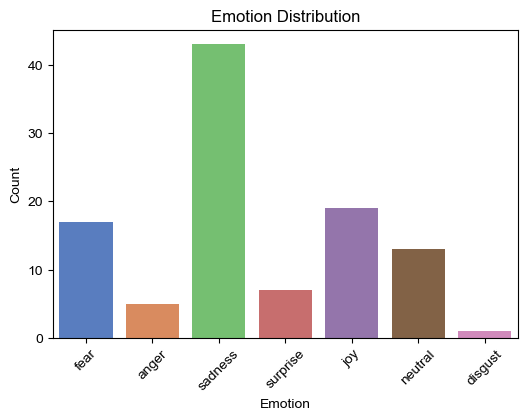

In [30]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Emotion', palette='muted')
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20)  # Limit to top 20 features for simplicity

# Compute TF-IDF on processed lyrics
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Lyrics'])

# Get feature names (words)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame for easier analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)

# Add TF-IDF results to the main DataFrame (e.g., top word per song)
df['Top_TFIDF_Word'] = tfidf_df.idxmax(axis=1)

In [32]:
print("Top TF-IDF Words per Song (Sample):")
print(df[['Song Title', 'Top_TFIDF_Word']].head())

Top TF-IDF Words per Song (Sample):
         Song Title Top_TFIDF_Word
0         متخفش مني          حبيبى
1        أجمل إحساس           قلبى
2        أسعد واحدة             دى
3     أغلى الحبايب           حياتى
4  أنا بستغرب عليه            حاجه


/var/folders/ln/886ccf112yvckr1xgsr6znnm0000gn/T/ipykernel_71698/2443868278.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tfidf_sums.values, y=tfidf_sums.index, palette='coolwarm')


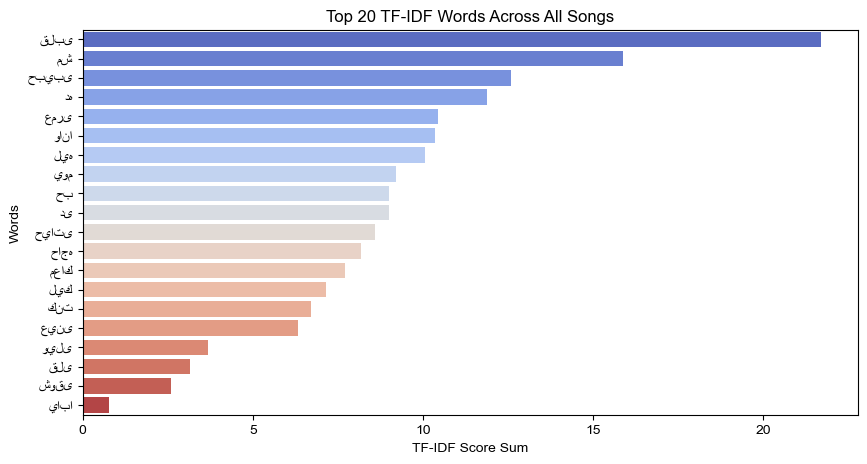

In [33]:
tfidf_sums = tfidf_df.sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=tfidf_sums.values, y=tfidf_sums.index, palette='coolwarm')
plt.title("Top 20 TF-IDF Words Across All Songs")
plt.xlabel("TF-IDF Score Sum")
plt.ylabel("Words")
plt.show()

In [34]:
# Save updated DataFrame with emotion and TF-IDF results
output_file_updated = 'C:\\Users\\Kimo Store\\Downloads\\deep\\output\\elissa_lyrics_preprocessed_with_emotion_tfidf.csv'
df.to_csv(output_file_updated, index=False, encoding='utf-8-sig')
print(f"Updated DataFrame with emotion and TF-IDF saved to {output_file_updated}")

Updated DataFrame with emotion and TF-IDF saved to C:\Users\Kimo Store\Downloads\deep\output\elissa_lyrics_preprocessed_with_emotion_tfidf.csv


In [35]:
# Group by Lyricist and compute sentiment distribution
lyricist_sentiment = df.groupby('Lyricist')['Sentiment_BERT'].value_counts(normalize=True).unstack().fillna(0)
lyricist_sentiment = lyricist_sentiment[['positive', 'neutral', 'negative']]  # Ensure consistent order

# Group by Lyricist and compute emotion distribution
lyricist_emotion = df.groupby('Lyricist')['Emotion'].value_counts(normalize=True).unstack().fillna(0)

# Filter lyricists with at least 3 songs to ensure meaningful statistics
min_songs = 3
lyricist_counts = df['Lyricist'].value_counts()
valid_lyricists = lyricist_counts[lyricist_counts >= min_songs].index
lyricist_sentiment = lyricist_sentiment.loc[lyricist_sentiment.index.isin(valid_lyricists)]
lyricist_emotion = lyricist_emotion.loc[lyricist_emotion.index.isin(valid_lyricists)]

# Display results
print("Sentiment Distribution by Lyricist:")
print(lyricist_sentiment)
print("\nEmotion Distribution by Lyricist:")
print(lyricist_emotion)

Sentiment Distribution by Lyricist:
Sentiment_BERT  positive   neutral  negative
Lyricist                                    
احمد الجندى     0.000000  0.200000  0.800000
احمد مرزوق      0.333333  0.666667  0.000000
اسامه مصطفى     0.333333  0.000000  0.666667
الياس ناصر      0.833333  0.166667  0.000000
امير طعيمة      0.000000  0.750000  0.250000
امير طعيمه      0.000000  0.666667  0.333333
سلامه على       0.333333  0.333333  0.333333
على المولى      0.000000  1.000000  0.000000
محمد رفاعى      0.250000  0.000000  0.750000
مروان خورى      0.333333  0.333333  0.333333
نادر عبدالله    0.421053  0.263158  0.315789

Emotion Distribution by Lyricist:
Emotion          anger   disgust      fear       joy   neutral   sadness  \
Lyricist                                                                   
احمد الجندى   0.000000  0.000000  0.000000  0.200000  0.000000  0.800000   
احمد مرزوق    0.000000  0.000000  0.000000  0.333333  0.333333  0.333333   
اسامه مصطفى   0.000000  0.000000  0.3333

In [36]:
# Group by Composer and compute sentiment distribution
composer_sentiment = df.groupby('composer')['Sentiment_BERT'].value_counts(normalize=True).unstack().fillna(0)
composer_sentiment = composer_sentiment[['positive', 'neutral', 'negative']]

# Group by Composer and compute emotion distribution
composer_emotion = df.groupby('composer')['Emotion'].value_counts(normalize=True).unstack().fillna(0)

# Filter composers with at least 3 songs
composer_counts = df['composer'].value_counts()
valid_composers = composer_counts[composer_counts >= min_songs].index
composer_sentiment = composer_sentiment.loc[composer_sentiment.index.isin(valid_composers)]
composer_emotion = composer_emotion.loc[composer_emotion.index.isin(valid_composers)]

# Display results
print("Sentiment Distribution by Composer:")
print(composer_sentiment)
print("\nEmotion Distribution by Composer:")
print(composer_emotion)

Sentiment Distribution by Composer:
Sentiment_BERT  positive   neutral  negative
composer                                    
تامر عاشور      0.666667  0.000000  0.333333
تامر على        0.333333  0.333333  0.333333
رامى جمال       0.000000  0.500000  0.500000
سامر ابو طالب   0.250000  0.000000  0.750000
محمد رحيم       0.300000  0.300000  0.400000
محمد يحيى       0.285714  0.428571  0.285714
مدين            0.375000  0.125000  0.500000
مروان خورى      0.400000  0.400000  0.200000
ناصر الاسعد     0.000000  0.333333  0.666667
وليد سعد        0.142857  0.714286  0.142857

Emotion Distribution by Composer:
Emotion           anger  disgust      fear       joy   neutral   sadness  \
composer                                                                   
تامر عاشور     0.000000      0.0  0.000000  0.000000  0.333333  0.333333   
تامر على       0.000000      0.0  0.000000  0.333333  0.333333  0.333333   
رامى جمال      0.000000      0.0  0.000000  0.250000  0.500000  0.250000   
سامر ابو 

In [37]:
# Convert Sentiment_BERT to numerical scores
sentiment_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['Sentiment_Score'] = df['Sentiment_BERT'].map(sentiment_map)

# Kruskal-Wallis test for Lyricists
lyricist_groups = [df[df['Lyricist'] == lyricist]['Sentiment_Score'].values for lyricist in valid_lyricists]
if len(lyricist_groups) > 1:
    stat_lyricist, p_lyricist = kruskal(*lyricist_groups)
    print(f"Kruskal-Wallis Test for Lyricists: Statistic={stat_lyricist:.2f}, p-value={p_lyricist:.4f}")
    if p_lyricist < 0.05:
        print("Significant difference in sentiment across lyricists (p < 0.05)")
    else:
        print("No significant difference in sentiment across lyricists (p >= 0.05)")
else:
    print("Not enough lyricist groups for Kruskal-Wallis test.")

# Kruskal-Wallis test for Composers
composer_groups = [df[df['composer'] == composer]['Sentiment_Score'].values for composer in valid_composers]
if len(composer_groups) > 1:
    stat_composer, p_composer = kruskal(*composer_groups)
    print(f"Kruskal-Wallis Test for Composers: Statistic={stat_composer:.2f}, p-value={p_composer:.4f}")
    if p_composer < 0.05:
        print("Significant difference in sentiment across composers (p < 0.05)")
    else:
        print("No significant difference in sentiment across composers (p >= 0.05)")
else:
    print("Not enough composer groups for Kruskal-Wallis test.")

Kruskal-Wallis Test for Lyricists: Statistic=14.60, p-value=0.1474
No significant difference in sentiment across lyricists (p >= 0.05)
Kruskal-Wallis Test for Composers: Statistic=5.38, p-value=0.7998
No significant difference in sentiment across composers (p >= 0.05)


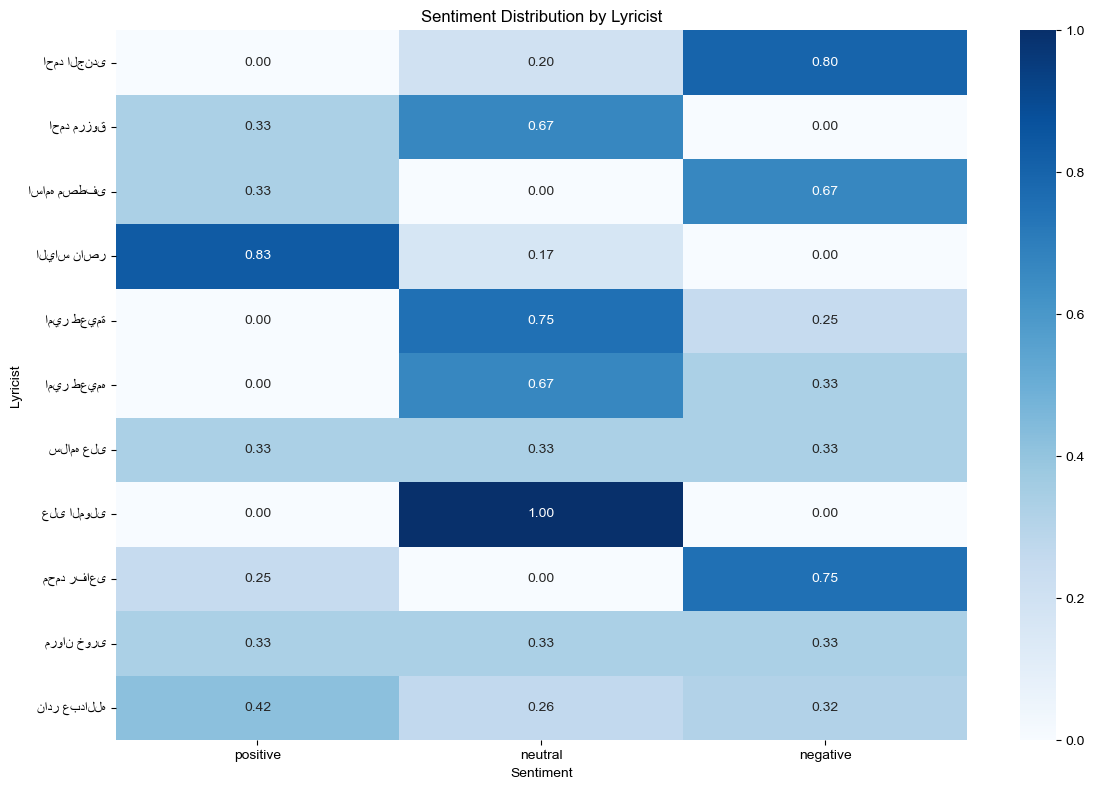

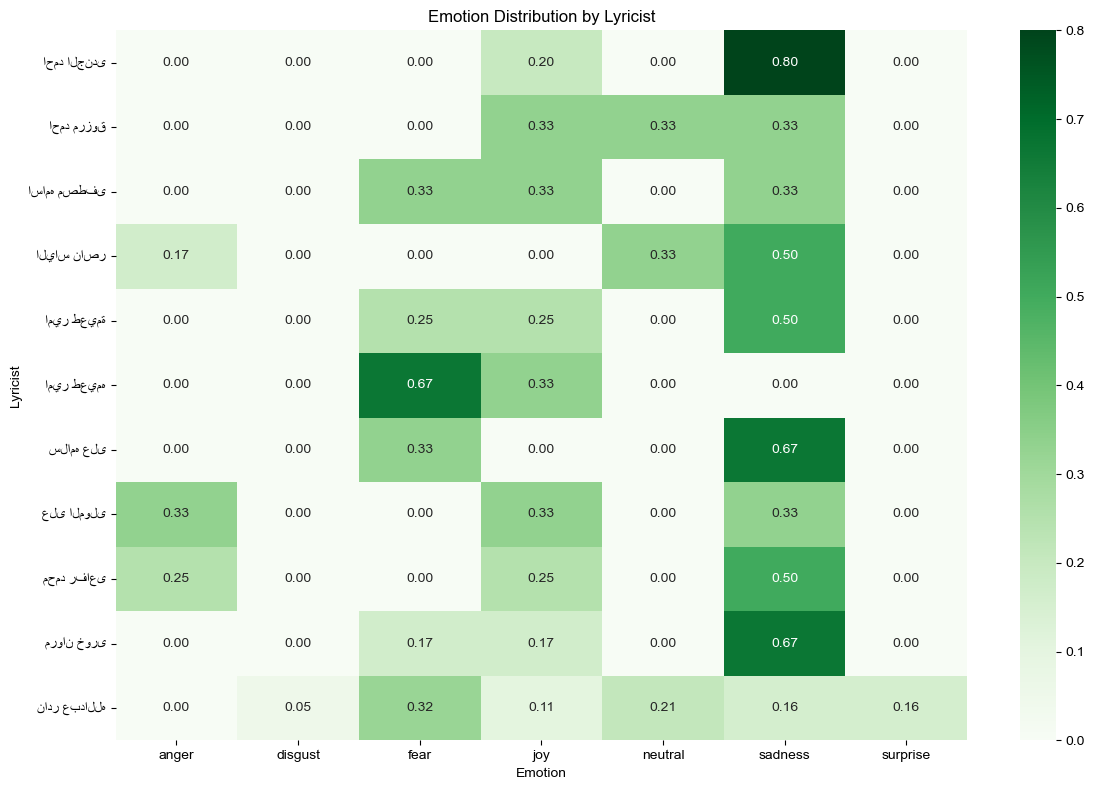

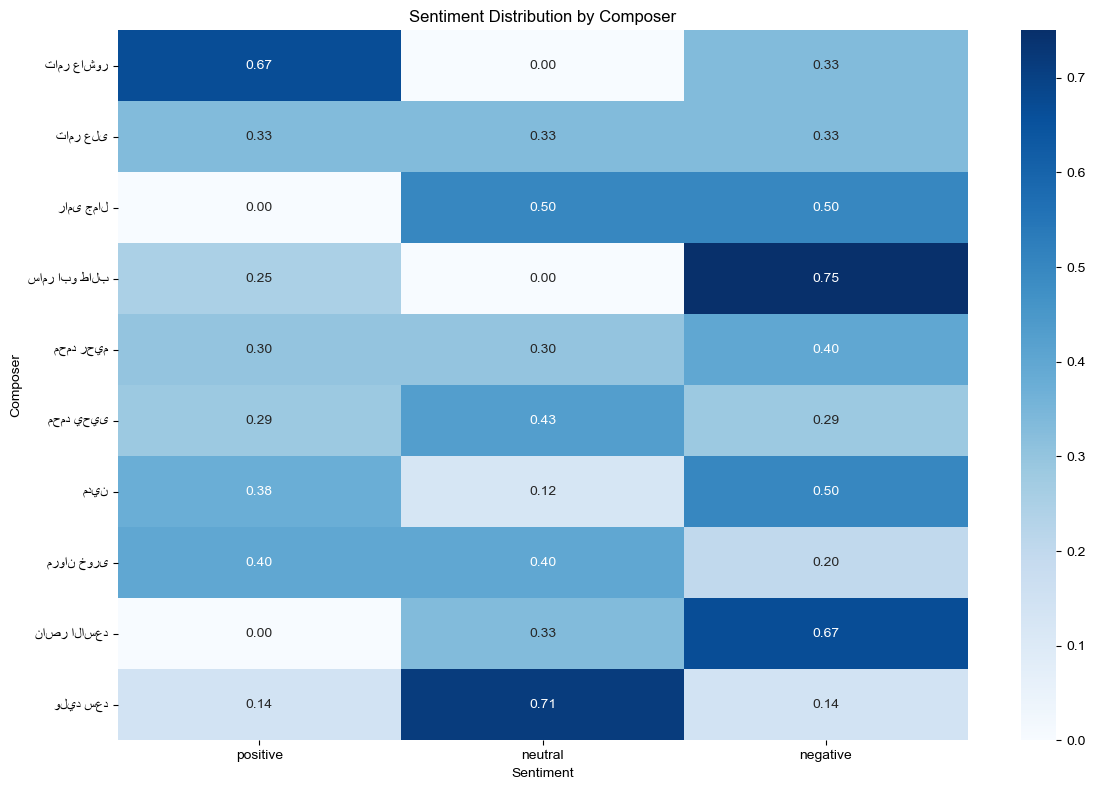

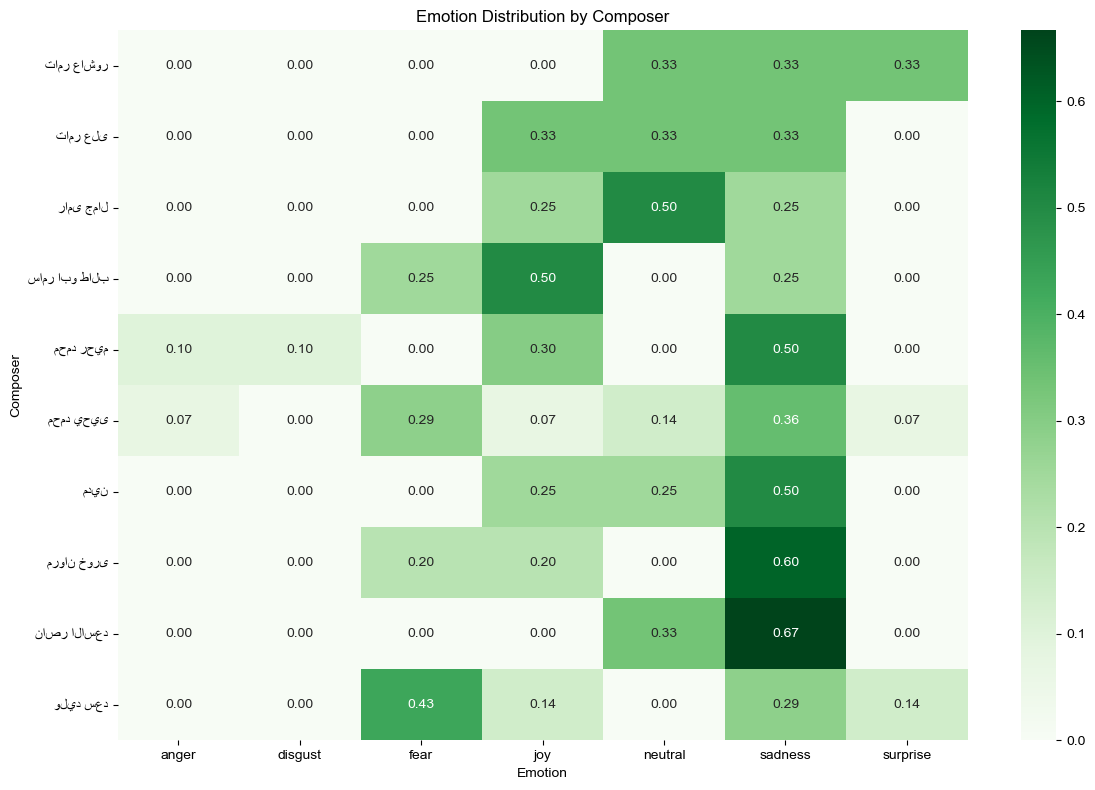

In [38]:
# Sentiment Heatmap for Lyricists
plt.figure(figsize=(12, 8))
sns.heatmap(lyricist_sentiment, annot=True, cmap='Blues', fmt='.2f')
plt.title('Sentiment Distribution by Lyricist')
plt.xlabel('Sentiment')
plt.ylabel('Lyricist')
plt.tight_layout()
plt.show()

# Emotion Heatmap for Lyricists
plt.figure(figsize=(12, 8))
sns.heatmap(lyricist_emotion, annot=True, cmap='Greens', fmt='.2f')
plt.title('Emotion Distribution by Lyricist')
plt.xlabel('Emotion')
plt.ylabel('Lyricist')
plt.tight_layout()
plt.show()

# Sentiment Heatmap for Composers
plt.figure(figsize=(12, 8))
sns.heatmap(composer_sentiment, annot=True, cmap='Blues', fmt='.2f')
plt.title('Sentiment Distribution by Composer')
plt.xlabel('Sentiment')
plt.ylabel('Composer')
plt.tight_layout()
plt.show()

# Emotion Heatmap for Composers
plt.figure(figsize=(12, 8))
sns.heatmap(composer_emotion, annot=True, cmap='Greens', fmt='.2f')
plt.title('Emotion Distribution by Composer')
plt.xlabel('Emotion')
plt.ylabel('Composer')
plt.tight_layout()
plt.show()

In [39]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year']).copy()
df['year'] = df['year'].astype(int)

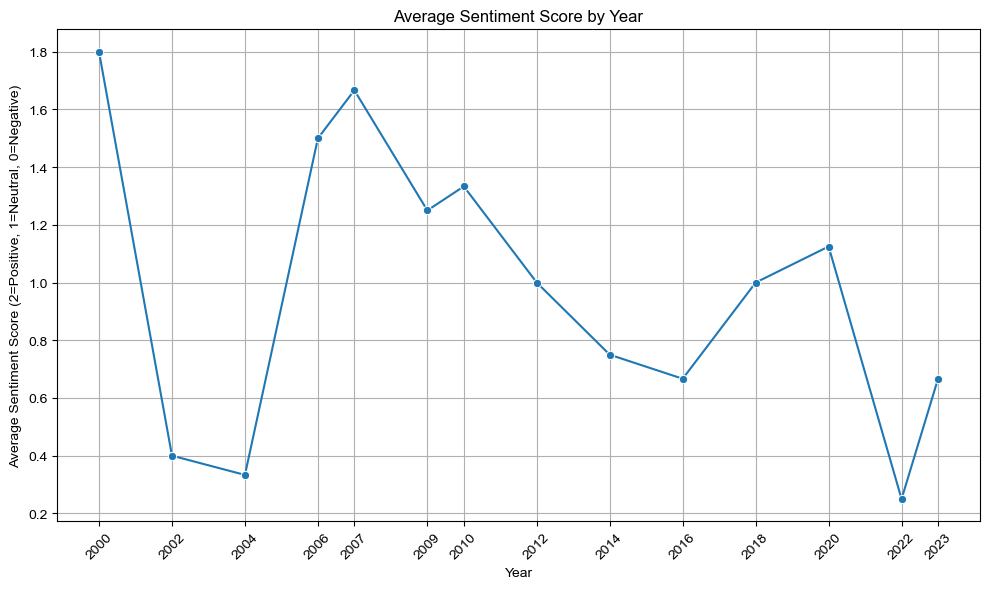

Spearman Correlation for Sentiment Score vs. Year: Correlation=-0.38, p-value=0.1816
No significant trend in sentiment over time (p >= 0.05)


In [40]:
# Group by year and compute average Sentiment_Score
sentiment_by_year = df.groupby('year')['Sentiment_Score'].mean().reset_index()

# Filter years with at least 3 songs for reliable statistics
year_counts = df['year'].value_counts()
valid_years = year_counts[year_counts >= 3].index
sentiment_by_year = sentiment_by_year[sentiment_by_year['year'].isin(valid_years)]

# Plot sentiment trend
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='Sentiment_Score', data=sentiment_by_year, marker='o')
plt.title('Average Sentiment Score by Year')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score (2=Positive, 1=Neutral, 0=Negative)')
plt.grid(True)
plt.xticks(sentiment_by_year['year'].astype(int), rotation=45)
plt.tight_layout()
plt.show()

# Spearman correlation test for sentiment trend
corr, p_value = spearmanr(sentiment_by_year['year'], sentiment_by_year['Sentiment_Score'])
print(f"Spearman Correlation for Sentiment Score vs. Year: Correlation={corr:.2f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Significant trend in sentiment over time (p < 0.05)")
else:
    print("No significant trend in sentiment over time (p >= 0.05)")

<Figure size 1200x800 with 0 Axes>

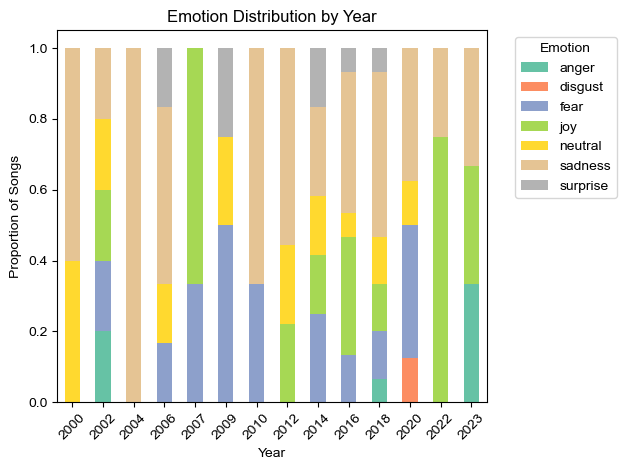

Emotion Distribution by Year:
Emotion     anger  disgust      fear       joy   neutral   sadness  surprise
year                                                                        
2000     0.000000    0.000  0.000000  0.000000  0.400000  0.600000  0.000000
2002     0.200000    0.000  0.200000  0.200000  0.200000  0.200000  0.000000
2004     0.000000    0.000  0.000000  0.000000  0.000000  1.000000  0.000000
2006     0.000000    0.000  0.166667  0.000000  0.166667  0.500000  0.166667
2007     0.000000    0.000  0.333333  0.666667  0.000000  0.000000  0.000000
2009     0.000000    0.000  0.500000  0.000000  0.250000  0.000000  0.250000
2010     0.000000    0.000  0.333333  0.000000  0.000000  0.666667  0.000000
2012     0.000000    0.000  0.000000  0.222222  0.222222  0.555556  0.000000
2014     0.000000    0.000  0.250000  0.166667  0.166667  0.250000  0.166667
2016     0.000000    0.000  0.133333  0.333333  0.066667  0.400000  0.066667
2018     0.066667    0.000  0.133333  0.133333

In [41]:
# Group by year and compute emotion distribution
emotion_by_year = df.groupby('year')['Emotion'].value_counts(normalize=True).unstack().fillna(0)
emotion_by_year = emotion_by_year.loc[emotion_by_year.index.isin(valid_years)]

# Plot stacked bar chart
plt.figure(figsize=(12, 8))
emotion_by_year.plot(kind='bar', stacked=True, cmap='Set2')
plt.title('Emotion Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Songs')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display emotion distribution
print("Emotion Distribution by Year:")
print(emotion_by_year)

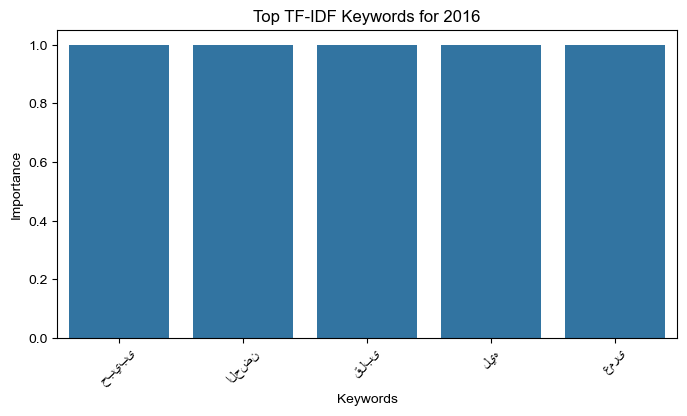

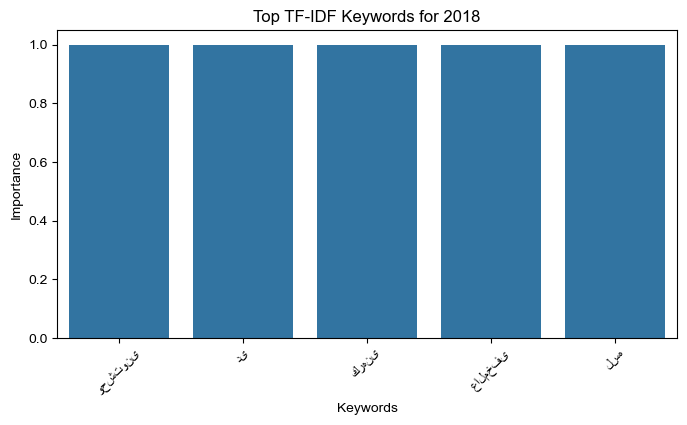

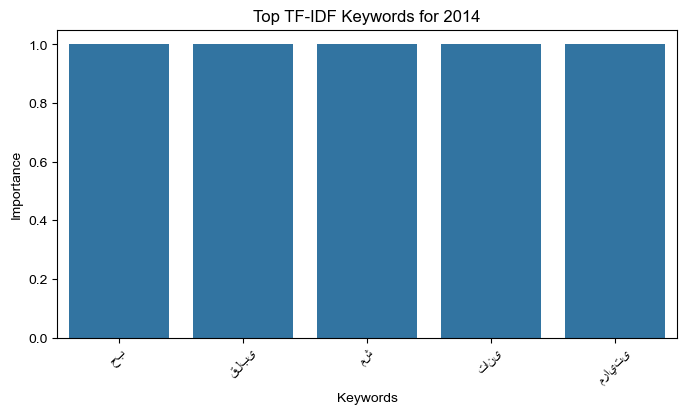

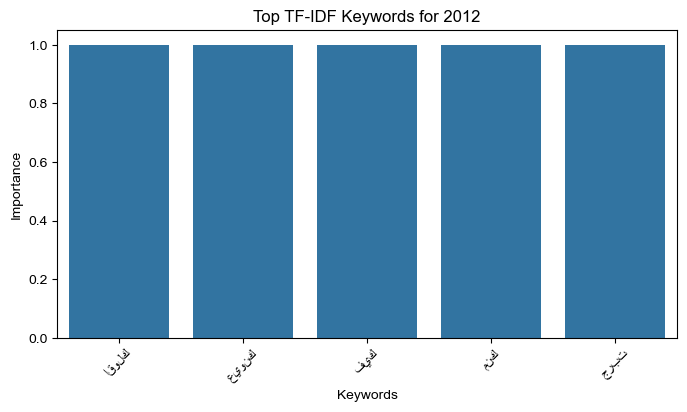

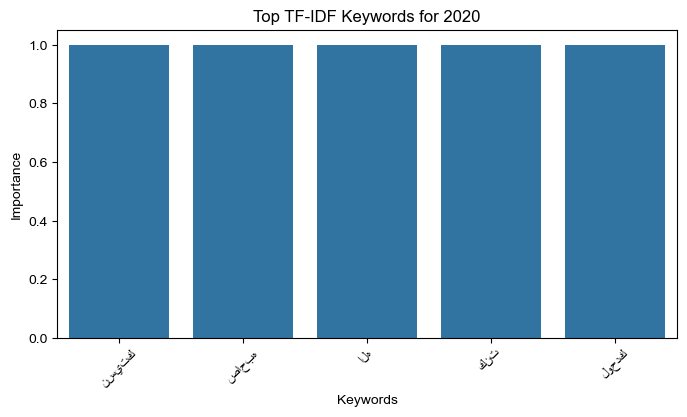

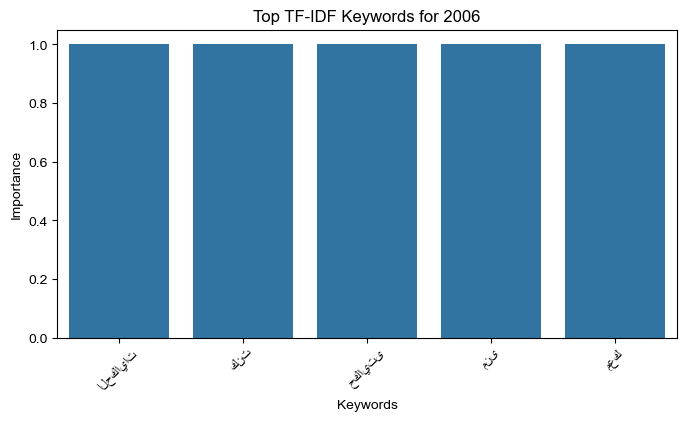

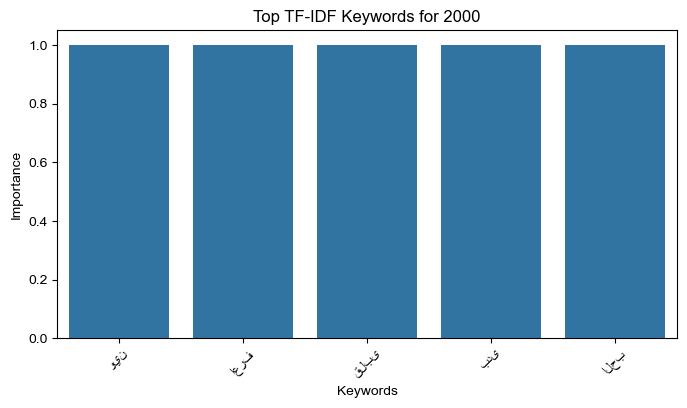

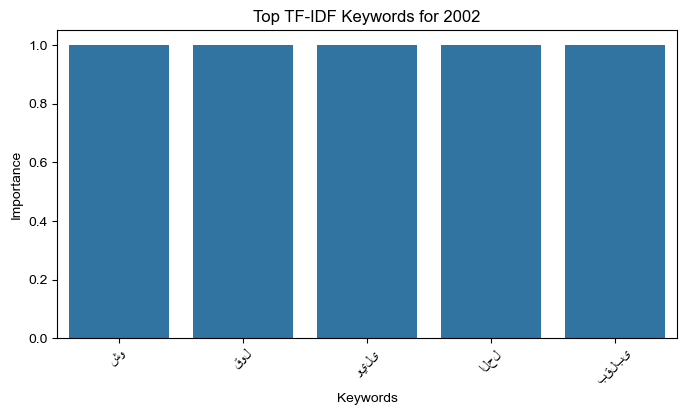

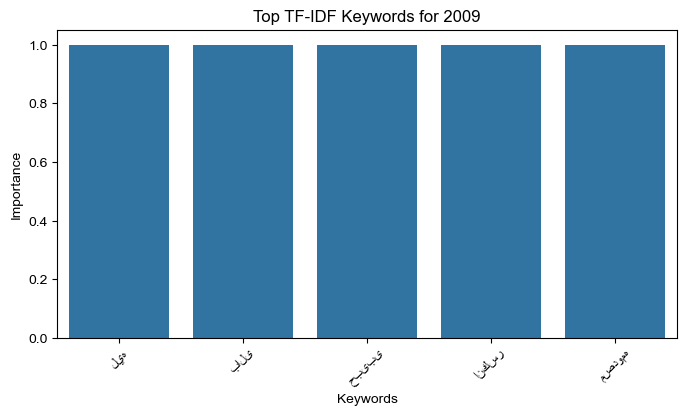

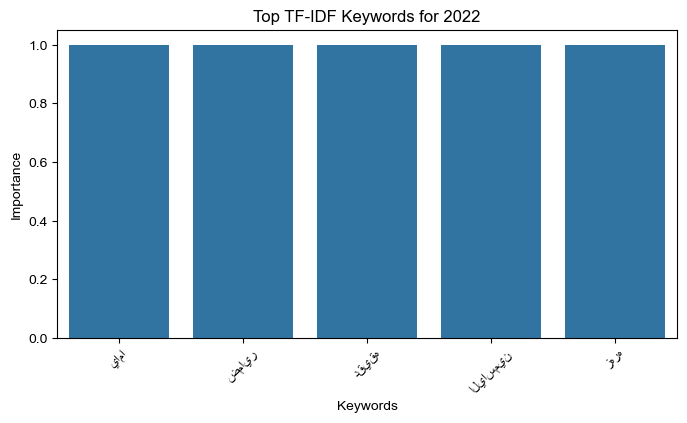

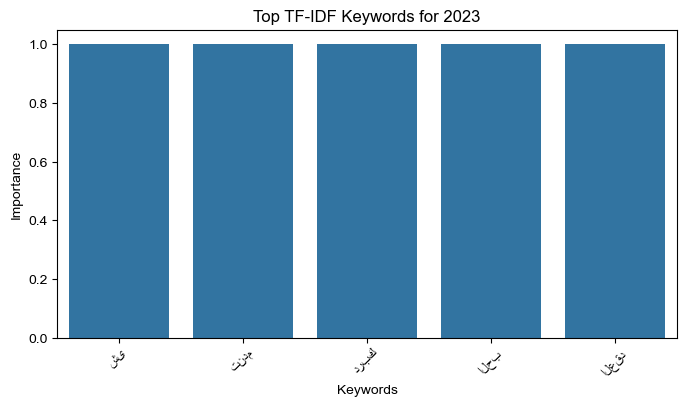

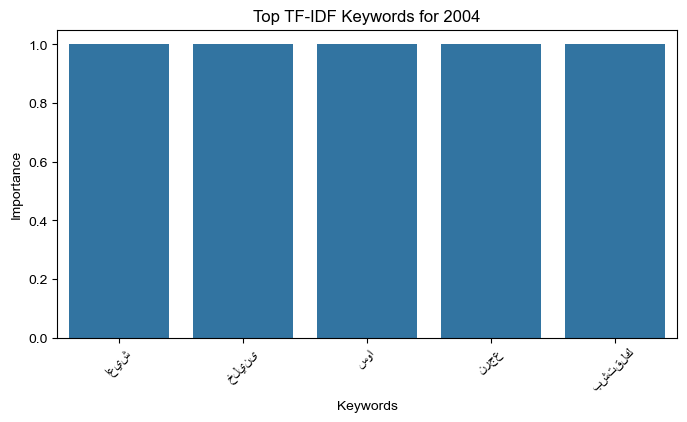

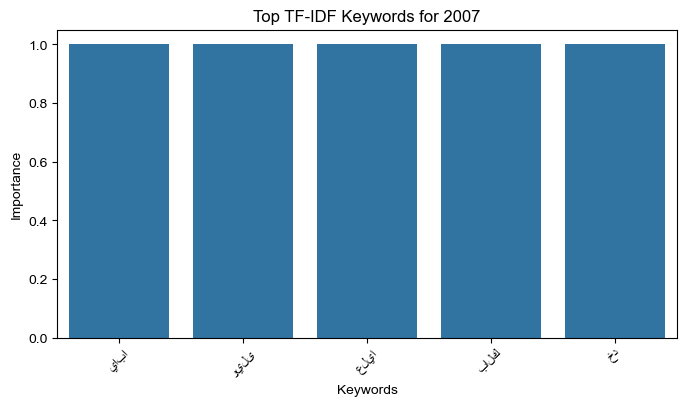

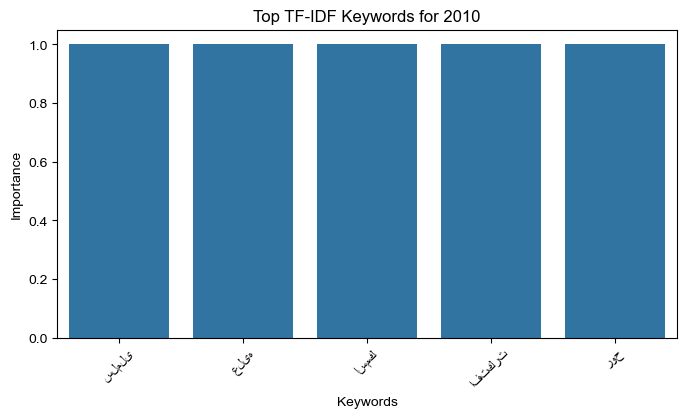

Top TF-IDF Keywords by Year:
2016: حبيبى, الحضن, قلبى, ليه, عمرى
2018: وحشتونى, دى, كرهنى, عالمخفى, لسه
2014: حب, قلبى, مش, تانى, مرايتى
2012: اقولك, عيونك, فيك, منك, جربت
2020: نسيتك, صاحبه, اله, كنت, لوحدك
2006: الحكايات, كنت, حكايتى, منى, معك
2000: وين, اعرف, قلبى, بدى, الحب
2002: شو, قول, ويلى, الحل, بقلبى
2009: ليه, بالی, حبیبی, انكسر, مصدومه
2022: ياما, ضماير, دقيقه, الياسمين, زهره
2023: شى, تندم, دربك, الحب, العقد
2004: اعيش, خلينى, سوا, نرجع, بشتقلك
2007: يابا, ويلى, عليا, بالك, خد
2010: سلملی, علیه, اسمك, افتكرت, روح


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to extract top TF-IDF words
def get_top_tfidf_words(texts, n=5):
    # Check if texts is empty or all elements are NaN
    if texts.empty or texts.isna().all():
        return []
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf.fit_transform(texts)
    feature_names = tfidf.get_feature_names_out()
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[-n:][::-1]
    return [feature_names[i] for i in top_indices]

# Group lyrics by year and extract top TF-IDF words
themes_by_year = {}
for year in valid_years:
    year_lyrics = df[df['year'] == year]['Processed_Lyrics'].dropna()
    if len(year_lyrics) >= 3:
        top_words = get_top_tfidf_words(year_lyrics, n=5)
        themes_by_year[year] = top_words

# Generate word clouds for each year
for year, words in themes_by_year.items():
    if words:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=words, y=[1]*len(words))
        plt.title(f'Top TF-IDF Keywords for {year}')
        plt.xlabel('Keywords')
        plt.ylabel('Importance')
        plt.xticks(rotation=45)
        plt.show()

# Display themes
print("Top TF-IDF Keywords by Year:")
for year, words in themes_by_year.items():
    print(f"{year}: {', '.join(words)}")

In [43]:
!pip install transformers datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [44]:
import re
import random
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec

# Function to remove diacritics only (for AraVec compatibility)
def remove_diacritics_only(text):
    diacritics = r'[\u0617-\u061A\u064B-\u065F]'
    return re.sub(diacritics, '', text)

# Prepare stop words with diacritics removed
nltk_arabic_stopwords = set(stopwords.words('arabic'))
stopwords_no_diacritics = {remove_diacritics_only(word) for word in nltk_arabic_stopwords}

# Tokenize and calculate word frequencies from original lyrics
def tokenize_text(text):
    return [word for word in text.split() if word.strip()]

all_tokens = []
for lyrics in df['Lyrics']:
    tokens = tokenize_text(lyrics)
    tokens_no_diacritics = [remove_diacritics_only(token) for token in tokens]
    all_tokens.extend([token for token in tokens_no_diacritics if token not in stopwords_no_diacritics])

word_freq = Counter(all_tokens)
top_words = [word for word, count in word_freq.most_common(50)]

# Load the AraVec model (update the path after downloading)
try:
    model = Word2Vec.load("/Users/malakashour/Downloads/Twt-CBOW/Twt-CBOW")
except FileNotFoundError:
    print("Error: Model file not found. Please check the path.")
    raise

# Build the synonym dictionary
synonyms_dict = {}
for word in top_words:
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=5)
        synonyms = [w for w, sim in similar_words if sim > 0.7]
        if synonyms:
            synonyms_dict[word] = synonyms

# Preview the synonym dictionary
print("Expanded Synonym Dictionary Sample:")
for word, syns in list(synonyms_dict.items())[:5]:
    print(f"{word}: {syns}")

Expanded Synonym Dictionary Sample:
انا: ['وانا', 'لاني']
قلبي: ['فؤادي', 'قلبك', 'وقلبي']
اللي: ['واللي', 'للي']
مش: ['ومش', 'موش', 'فمش', 'بردو', 'برضه']
حبيبي: ['ياحبيبي']


In [45]:
# Synonym replacement function for original lyrics
def synonym_replacement_original(text, synonym_dict, n=2):
    words = text.split()
    new_words = words.copy()
    replaced = 0
    attempts = 0
    max_attempts = len(words) * 2  # Avoid infinite loops
    
    while replaced < n and attempts < max_attempts:
        word_idx = random.randint(0, len(words) - 1)
        word = remove_diacritics_only(words[word_idx])
        if word in synonym_dict:
            synonym = random.choice(synonym_dict[word])
            new_words[word_idx] = synonym  # Replace the selected word
            replaced += 1
        attempts += 1
    
    return ' '.join(new_words)

# Apply synonym replacement to original lyrics
df['Augmented_Lyrics_Syn_Original'] = df['Lyrics'].apply(
    lambda x: synonym_replacement_original(x, synonyms_dict, n=2)
)

# Preprocess the augmented lyrics (assuming preprocess_text is defined elsewhere)
df['Augmented_Processed_Lyrics_Syn'] = df['Augmented_Lyrics_Syn_Original'].apply(preprocess_text)

# Save the updated DataFrame
output_file = '/Users/malakashour/Downloads/elissa_lyrics_preprocessed_augmented.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"Preprocessed lyrics saved to {output_file}")
print(df[['Song Title', 'Lyrics', 'Augmented_Lyrics_Syn_Original', 'Augmented_Processed_Lyrics_Syn']].head())

Preprocessed lyrics saved to /Users/malakashour/Downloads/elissa_lyrics_preprocessed_augmented.csv
         Song Title                                             Lyrics  \
0         متخفش مني  متخفش مني\nمتخفش مني\nمتخفش مني\nمتخفش مني\nأن...   
1        أجمل إحساس  أجمل إحساس\nأجمل إحساس\nأجمل إحساس\nأجمل إحساس...   
2        أسعد واحدة  أسعد واحدة\nأسعد واحدة\nأسعد واحدة\nالفرحة الل...   
3     أغلى الحبايب   أغلى الحبايب\nأغلى الحبايب\nأغلى الحبايب\nأغلى...   
4  أنا بستغرب عليه   أنا بستغرب عليه\nأنا بستغرب عليه\nأنا بستغرب ع...   

                       Augmented_Lyrics_Syn_Original  \
0  متخفش مني متخفش مني متخفش مني متخفش مني أنا أل...   
1  أجمل إحساس أجمل إحساس أجمل إحساس أجمل إحساس فى...   
2  أسعد واحدة أسعد واحدة أسعد واحدة الفرحة اللي أ...   
3  أغلى الحبايب أغلى الحبايب أغلى الحبايب أغلى ال...   
4  أنا بستغرب عليه أنا بستغرب عليه أنا بستغرب علي...   

                      Augmented_Processed_Lyrics_Syn  
0  متخفش\nمنى\nمتخفش\nمنى\nمتخفش\nمنى\nمتخفش\nمنى...  
1  اجمل\n

In [46]:
# Write original preprocessed lyrics to train.txt
with open('train.txt', 'w', encoding='utf-8') as f:
    for lyrics in df['Processed_Lyrics']:
        f.write(lyrics + '\n')

# Append synonym-replaced preprocessed lyrics
with open('train.txt', 'a', encoding='utf-8') as f:
    for lyrics in df['Augmented_Processed_Lyrics_Syn']:
        f.write(lyrics + '\n')

In [47]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained AraGPT2 model and tokenizer
model_name = "aubmindlab/aragpt2-base"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [48]:
from transformers import Trainer, TrainingArguments, TextDataset, DataCollatorForLanguageModeling

# Load the dataset from train.txt
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="train.txt",
    block_size=128,  # Adjust based on your GPU memory
)

# Define the data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # GPT-2 is a causal language model, not masked
)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Reduce if memory issues occur
    save_steps=10_000,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=500,
    prediction_loss_only=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")
print("Model fine-tuning completed and saved to ./fine_tuned_model")

/opt/anaconda3/lib/python3.12/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


Model fine-tuning completed and saved to ./fine_tuned_model


In [49]:
from transformers import AutoModelForCausalLM, AutoTokenizer

try:
    tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_model")
    model = AutoModelForCausalLM.from_pretrained("./fine_tuned_model")
    print("Model and tokenizer loaded successfully")
except Exception as e:
    print(f"Error loading model/tokenizer: {e}")

Model and tokenizer loaded successfully


In [50]:
import torch
from transformers import pipeline, AutoTokenizer

# Set device
device = "cpu" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Load tokenizer to configure padding
try:
    tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_model")
    tokenizer.pad_token = tokenizer.eos_token  # Set padding token
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    exit()

# Load the fine-tuned model for text generation
try:
    generator = pipeline(
        'text-generation',
        model='./fine_tuned_model',
        tokenizer=tokenizer,
        device=device
    )
except Exception as e:
    print(f"Error loading pipeline: {e}")
    exit()

# Provide a seed text
seed_text = "حبيبي"  # "My love" in Arabic

# Generate lyrics
try:
    generated_lyrics = generator(
        seed_text,
        max_length=100,  # Total sequence length
        num_return_sequences=1,
        temperature=0.7,
        top_k=50,
        top_p=0.9,
        truncation=True  # Explicitly enable truncation
    )
    print("Generated Lyrics:")
    print(generated_lyrics[0]['generated_text'])
except Exception as e:
    print(f"Generation error: {e}")

Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Using device: cpu
Generated Lyrics:
حبيبيبى
بستناك
قلبى
عليا
احساسى
اعيش
اسمك
تانى
معاك
عمرى
مشاعرهواك
واخدنى
اتقابلنا
حياتى
روحى
الحياه
الدنيا
الايام
نسيتك
شايفينها
عمرك
بعدك
سنين
العمر
جنان
خليك
عينيالى
حبك
غايب
بحبك
فيك
حياه
واحده
بتمنى
شوقى
ليالى
قلبك
كنت
وانا
بقلبى
قبلك
ايديك
كانى
يابا
الياسمين
تبقى
ويلى
وقلبك
وياك
وبعدك
محيت
وحدى
يبقى
بقى
يوم
اهتمام
اقولك
مافيك
متعرفش
منك
بنسى
وانت
فزعانه
ومرتاح
وعشان
عيونك
بخاف
كتير
صعب
نفسى
رضيك
طريقه
تروح
لحظه
وحشتونى
الناس
انسان
هنعيش
وصوتك
شو
بيناموت



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract top TF-IDF words from generated lyrics
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform([generated_lyrics[0]['generated_text']])
feature_names = tfidf.get_feature_names_out()
top_words = [feature_names[i] for i in tfidf_matrix.toarray().argsort()[0, -5:][::-1]]

print(f"Top TF-IDF words in generated lyrics: {', '.join(top_words)}")

Top TF-IDF words in generated lyrics: يوم, يبقى, بستناك, بسهر, بعدك
